In [19]:
mkdir img

mkdir: cannot create directory ‘img’: File exists


In [1]:
"""Imported Modules"""
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape,LeakyReLU,BatchNormalization,Dense,Conv2D,Conv2DTranspose,Flatten,Input
from tensorflow.keras.models import Sequential,Model
from keras.optimizers import Adam
from tensorflow.keras.datasets import mnist


In [2]:
"""Loading Dataset"""
(X_train, y_train), (_, _) = mnist.load_data()

In [3]:
"""Expanding the dims and resizing the array"""
X_train = np.expand_dims(X_train, axis=3)
X_train = tf.image.resize(X_train, (32, 32))

In [5]:
X_train.shape

TensorShape([60000, 32, 32, 1])

In [6]:
"""Converting it into numpy array"""
list = np.array(X_train)
list = list.astype('float32')
list = (list - 127.5) / 127.5

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(list)
dataset = dataset.shuffle(buffer_size=300).batch(16).prefetch(buffer_size=16)

In [10]:
"""for real_images in dataset:
    print("Shape of real_images:", real_images.shape)  # Print the shape
    batch_size = real_images.shape[0]"""

'for real_images in dataset:\n    print("Shape of real_images:", real_images.shape)  # Print the shape\n    batch_size = real_images.shape[0]'

In [11]:
"""Define Generator"""
def generator_model():
    input = (100,)
    model = Sequential()
    model.add(Dense(4* 4* 32, input_shape=input))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 32)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(16, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(8, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2 ,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(1, kernel_size=4,padding='same',activation="tanh"))
    model.summary()
    return model


In [12]:
"""Define Discriminator"""
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(3, kernel_size=3, strides=2, padding='same', input_shape=(32,32,1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(8, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(16, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    optimizer = Adam(0.0002, 0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



In [13]:
"""Generator Training function"""
def Gant(generator,discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.summary()
    optimizer = Adam(0.0002, 0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

In [14]:
"""Training of both Discriminator and Generator"""
def train(dataset,epochs=500,batch_size=16,save_interval=100):

    for epoch in range(epochs):
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Train Discriminator with a full batch of real images
            noise = np.random.normal(0, 1, (batch_size, 100))
            gen_images = generator.predict(noise)

            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(gen_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            valid_y = np.ones((batch_size, 1))

            g_loss = Gant.train_on_batch(noise, valid_y)

            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = Gant.train_on_batch(noise, valid_y)

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")
        save_imgs(epoch)


In [15]:
"""Function saving the generated images"""
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"/content/img_{epoch}.png")
    plt.close()

In [16]:
discriminator = discriminator_model()
generator = generator_model()
Gant = Gant(generator,discriminator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 3)         30        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           224       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 8)           0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 16)          1168      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 16)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 32)          4

In [25]:
train(dataset,2,1)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
0/2 [D loss: 0.6939471364021301 | D accuracy: 59.38%] [G loss: 0.6863213777542114]
1/1 [==============================] - 0s 19ms/step
1/2 [D loss: 0.6937052309513092 | D accuracy: 46.88%] [G loss: 0.688438892364502]
1/1 [==============================] - 0s 19ms/step


SAVE THE TRAINED GENERATOR

In [26]:
"""Saving generator"""
generator.save('/content/drive/MyDrive/gan_model.h5')

In [27]:
from tensorflow.keras.models import load_model

LOAD AND PREDICT USING THE SAVED MODEL

In [28]:
"""Loading the saved Model"""
model = load_model('/content/drive/MyDrive/gan_model.h5')

In [29]:
"""Creating a random noise"""
test = np.random.normal(0, 1, (1, 100))


In [30]:
test.shape

(1, 100)

In [31]:
"""Predicting using the model"""
img = model.predict(test)

1/1 [==============================] - 0s 193ms/step


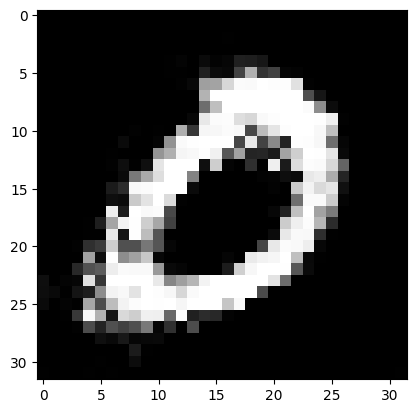

<Figure size 500x500 with 0 Axes>

In [32]:
"""Displaying the generated image"""
plt.imshow(img[0],cmap="gray")
plt.figure(figsize=(5,5))
plt.show()